<a href="https://colab.research.google.com/github/lidan1/case/blob/main/eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Folder

Fisrt mount google drive

In [ ]:
import os
if not os.path.isdir('./drive'):
  from google.colab import drive
  drive.mount('/content/drive')

In [ ]:
if not os.path.isdir('./data'):
  !mkdir ./data
  !cp ./drive/MyDrive/apple/data.zip ./data/
  !cd ./data && unzip -q data.zip

In [ ]:
# !rm -r ./data

Load Data


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

data_transforms = {
    'train': transforms.Compose([
        # transforms.Resize(246),
        # transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=False, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Define Validation Function

In [ ]:
def validation(model):
    model.eval()
    images_so_far = 0
    with torch.no_grad():
        running_loss = 0.0
        running_corrects = 0
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            # Move input and label tensors to the default device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(inputs)
            # print(outputs)
            _, preds = torch.max(outputs, 1)
            print(preds.item())
            # calculate accuracy
            running_corrects += torch.sum(preds == labels.data)
            epoch_acc = running_corrects.double() / dataset_sizes['val']
        print('{} Acc: {:.4f}'.format('val', epoch_acc))


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Define Model and Load pretrained weights

In [ ]:
# ResNet models
# model = models.resnet18(pretrained=False)
# model = models.resnet50(pretrained=False)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, len(class_names))
# # PATH = 'drive/MyDrive/apple/model/res18_0.9833.pth'
# PATH = 'drive/MyDrive/apple/model/res50_0.9827.pth'
# model.load_state_dict(torch.load(PATH, map_location=device))
# model = model.to(device)

# VGG models
model = models.vgg19_bn(pretrained=False)
model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 2048),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(2048, 1024),
    nn.ReLU(True),
    nn.Dropout(),
    nn.Linear(1024, 3),
)
PATH = 'drive/MyDrive/apple/model/vgg19bn_0.986.pth'
model.load_state_dict(torch.load(PATH, map_location=device))
model = model.to(device)

In [ ]:
# validation(model)

Test and Evaluation

In [ ]:
model.eval()
images_so_far = 0
with torch.no_grad():
    running_loss = 0.0
    running_corrects = 0
    a_tp, a_fp, a_tn, a_fn = 0, 0, 0, 0
    b_tp, b_fp, b_tn, b_fn = 0, 0, 0, 0
    c_tp, c_fp, c_tn, c_fn = 0, 0, 0, 0

    y_pred = []
    y_true = []
    for i, (inputs, labels) in enumerate(dataloaders['val']):
        # Move input and label tensors to the default device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(inputs)
        # print(outputs)
        _, preds = torch.max(outputs, 1)
        y_pred.append(preds.item())
        y_true.append(labels.data.item())
        # print(preds.item())
        # print(labels.data)
        # calculate accuracy
        running_corrects += torch.sum(preds == labels.data)
        a_tp += (labels.data.item() == 0 and preds.item() == 0)
        a_fp += (labels.data.item() != 0 and preds.item() == 0)
        a_tn += (labels.data.item() != 0 and preds.item() != 0)
        a_fn += (labels.data.item() == 0 and preds.item() != 0)

        b_tp += (labels.data.item() == 1 and preds.item() == 1)
        b_fp += (labels.data.item() != 1 and preds.item() == 1)
        b_tn += (labels.data.item() != 1 and preds.item() != 1)
        b_fn += (labels.data.item() == 1 and preds.item() != 1)
        
        c_tp += (labels.data.item() == 2 and preds.item() == 2)
        c_fp += (labels.data.item() != 2 and preds.item() == 2)
        c_tn += (labels.data.item() != 2 and preds.item() != 2)
        c_fn += (labels.data.item() == 2 and preds.item() != 2)


        epoch_acc = running_corrects.double() / dataset_sizes['val']
    print('{} Acc: {:.4f}'.format('val', epoch_acc))

val Acc: 0.9860


In [ ]:

print(running_corrects)
# print(i)
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

c_mat = confusion_matrix(y_true, y_pred)
print(c_mat)


tensor(1479, device='cuda:0')
[[497   3   0]
 [ 13 482   5]
 [  0   0 500]]


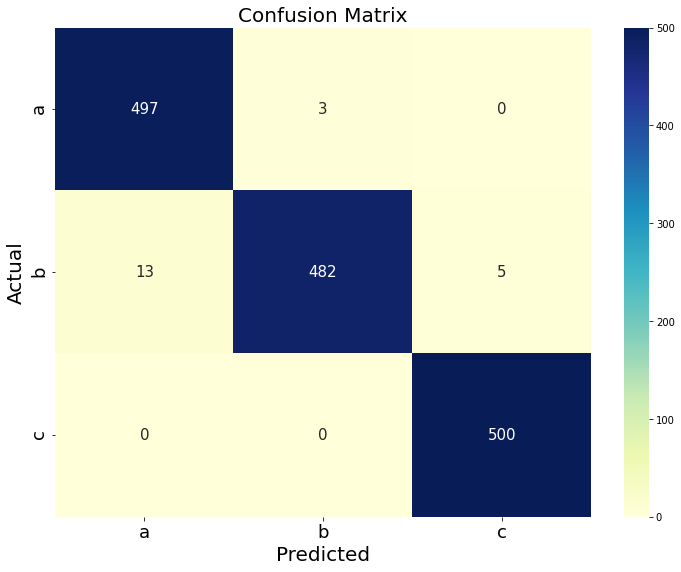

In [ ]:
df_cm = pd.DataFrame(c_mat, index = [i for i in "abc"], columns = [i for i in "abc"])
fig1 = plt.figure(figsize=(12,9))
# fig1 = plt.figure()
ax1 = fig1.gca()   #Get Current Axis
ax1.cla() # clear existing plot

#heatmap
ax = sn.heatmap(df_cm, annot=True, annot_kws={"size":15}, ax=ax1, fmt='d', cmap="YlGnBu")

#set ticklabels rotation
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 18)
ax.set_title('Confusion Matrix', fontsize = 20)
ylbl = 'Actual'
xlbl = 'Predicted'
ax.set_xlabel(xlbl, fontsize = 20)
ax.set_ylabel(ylbl, fontsize = 20)
plt.show()


In [ ]:
print('a_tp:', a_tp)
print('a_fp:', a_fp)
print('a_tn:', a_tn)
print('a_fn:', a_fn)
print('b_tp:', b_tp)
print('b_fp:', b_fp)
print('b_tn:', b_tn)
print('b_fn:', b_fn)
print('c_tp:', c_tp)
print('c_fp:', c_fp)
print('c_tn:', c_tn)
print('c_fn:', c_fn)

def precision(tp, fp):
    return tp/(tp + fp)

def recall(tp, fn):
    return tp/(tp + fn)
a_precision = precision(a_tp, a_fp)
a_recall = recall(a_tp, a_fn)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, digits=4, target_names=['a', 'b', 'c']))

a_tp: 497
a_fp: 13
a_tn: 987
a_fn: 3
b_tp: 482
b_fp: 3
b_tn: 997
b_fn: 18
c_tp: 500
c_fp: 5
c_tn: 995
c_fn: 0
              precision    recall  f1-score   support

           a     0.9745    0.9940    0.9842       500
           b     0.9938    0.9640    0.9787       500
           c     0.9901    1.0000    0.9950       500

    accuracy                         0.9860      1500
   macro avg     0.9861    0.9860    0.9860      1500
weighted avg     0.9861    0.9860    0.9860      1500



In [ ]:
def test_samples(model, num_images=10):
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            if preds.item() != labels.data.item():
                # print(preds)
                # print(labels.data)
                images_so_far += 1
                ax = plt.subplot(num_images+1, 1, images_so_far)
                ax.axis('off')
                ax.set_title('labels: {} predicted: {}'.format(class_names[labels], class_names[preds]))
                imshow(inputs.cpu().data[0])

            if images_so_far == num_images:
                plt.ioff()
                plt.show()
                return


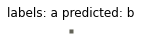

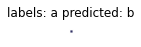

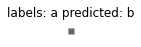

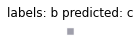

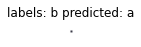

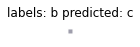

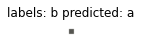

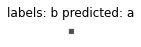

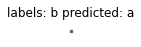

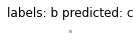

In [ ]:
test_samples(model)